In [ ]:
# Unet with ResNet 34 for multiclass semantic segmentation
!pip install tensorflow==2.1.0

In [ ]:
!pip install segmentation-models

In [3]:
# mount google drive here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Fetch the training, validation and testing dataset
import os
import numpy as np

dataPath  = '/content/drive/My Drive/Underwater_Segmentation_Research/Data'

trainPath =  dataPath + '/Train'
testPath  =  dataPath + '/Test'
valPath   =  dataPath + '/Validate'

trainImgsFile   = 'trainingDataImgs.npy'
trainLabelsFile = 'trainingDataLabels.npy'

testImgsFile    = 'testingDataImgs.npy'
testLabelsFile  = 'testingDataLabels.npy'

valImgsFile     = 'validationDataImgs.npy'
valLabelsFile   = 'validationDataLabels.npy'

def getData(path,fileName):
  return np.load(path + "/" + fileName)

trainImgs = getData(trainPath, trainImgsFile)
trainLabels = getData(trainPath, trainLabelsFile)

#testImgs   = getData(testPath, testImgsFile)
#testLabels = getData(testPath, testLabelsFile)

valImgs    = getData(valPath, valImgsFile)
valLabels  = getData(valPath, valLabelsFile)

print("Got train and validation data")
print(trainImgs.shape, valImgs.shape)
print(trainLabels.shape, valLabels.shape)

Got train and validation data
(1000, 480, 320, 1) (251, 480, 320, 1)
(1000, 480, 320, 1) (251, 480, 320, 1)


In [ ]:
# Create the model (without pre-trained ImageNet weights)
# BATCH_SIZE = 16
# EPOCHS     = 20 (use early stopping as well to avoid overfitting (and store the epochs till then))
import os
import numpy as np
import segmentation_models as sm

# create the model
model = sm.Unet('vgg16', input_shape=(480, 320, 1), encoder_weights=None, classes=12, activation='softmax')
model.summary()


In [8]:
# Compile the model with loss function, optimizer and metric
import tensorflow as tf
LOSS=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    'Adam',
    loss='sparse_categorical_crossentropy',
    metrics=[sm.metrics.iou_score,'accuracy'],
)

In [9]:
# Setup training parameters
BATCH = 16
EPOCHS = 30

# early stopping callback. It stops training when the loss does not change for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [10]:
# Start training the model

# change the label type to float32
# tf.cast(trainLabels, tf.float32)
# tf.cast(trainImgs, tf.float32)
# tf.cast(valLabels, tf.float32)
# tf.cast(valImgs, tf.float32)

history = model.fit(trainImgs, trainLabels, epochs=EPOCHS, batch_size=BATCH, validation_data=(valImgs, valLabels))

Train on 1000 samples, validate on 251 samples
Epoch 1/30
1000/1000 [==============================] - 50s 50ms/sample - loss: 0.9209 - iou_score: 0.0507 - accuracy: 0.7514 - val_loss: 1.2421 - val_iou_score: 0.0635 - val_accuracy: 0.4512
Epoch 2/30
1000/1000 [==============================] - 35s 35ms/sample - loss: 0.1916 - iou_score: 0.0404 - accuracy: 0.9632 - val_loss: 0.3349 - val_iou_score: 0.0594 - val_accuracy: 0.9613
Epoch 3/30
1000/1000 [==============================] - 35s 35ms/sample - loss: 0.1616 - iou_score: 0.0433 - accuracy: 0.9637 - val_loss: 0.1815 - val_iou_score: 0.0422 - val_accuracy: 0.9634
Epoch 4/30
1000/1000 [==============================] - 35s 35ms/sample - loss: 0.1495 - iou_score: 0.0451 - accuracy: 0.9643 - val_loss: 0.2239 - val_iou_score: 0.0292 - val_accuracy: 0.9623
Epoch 5/30
1000/1000 [==============================] - 35s 35ms/sample - loss: 0.1380 - iou_score: 0.0509 - accuracy: 0.9657 - val_loss: 0.3523 - val_iou_score: 0.0263 - val_accuracy: 

dict_keys(['loss', 'iou_score', 'accuracy', 'val_loss', 'val_iou_score', 'val_accuracy'])


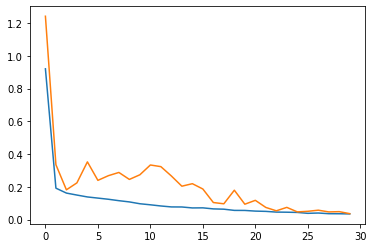

In [11]:
#  Plot the results
print(history.history.keys())

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

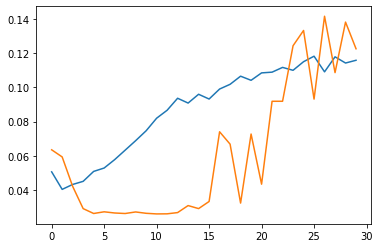

In [12]:
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])

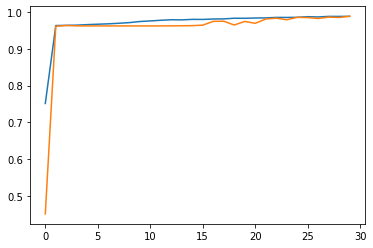

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [14]:
# get the testdata
testImgs   = getData(testPath, testImgsFile)
testLabels = getData(testPath, testLabelsFile)

In [15]:
model.evaluate(testImgs, testLabels)

617/617 [==============================] - 10s 15ms/sample - loss: 0.0357 - iou_score: 0.1221 - accuracy: 0.9885


[0.03572004455680592, 0.12214525, 0.9884707]

In [16]:
# save the model weights
weightFileName = "UVggNet16_30e_16b.h5"
weightPath = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/UNET'
model.save_weights(weightPath + "/" + weightFileName)


In [18]:
model.load_weights(weightPath + "/" + weightFileName)
model.evaluate(testImgs, testLabels)

617/617 [==============================] - 6s 10ms/sample - loss: 0.0357 - iou_score: 0.1221 - accuracy: 0.9885


[0.03572004455680592, 0.12214525, 0.9884707]

In [19]:
modelFileName = "UVggNet16_30e_16b"
modelPath     = '/content/drive/My Drive/Underwater_Segmentation_Research/Models/Unet'
model.save(modelPath + "/" + modelFileName)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Underwater_Segmentation_Research/Models/Unet/UVggNet16_30e_16b/assets


In [20]:
# Check the GPU configuration
!nvidia-smi

Tue Mar 30 07:16:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    34W / 250W |  15771MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
# check the outputs here
outputs = model.predict(testImgs)

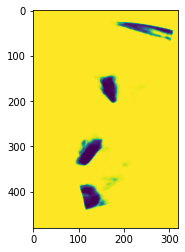

In [22]:
import matplotlib.pyplot as plt

img = outputs[0,:,:,0]
plt.imshow(img)
plt.show()

In [ ]:
outputs = None